<a href="https://colab.research.google.com/github/AntonAIG/energy_efficient_buildings/blob/secondary/ASHRAE_energy_eff/ashrae_building_eff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASHRAE - Great Energy Predictor III

Table of Contents:
* Introduction
* Business Problem
* Data Sources and Structure
* Proposed Solution
* Importing Data
* Exploratory Data Analysis
* Feature Engineering

## Introduction

Building sustainability has been in the fore front of renewable the green revolution and sustainable innovations. Building innovations that will improve sustainabilty have gained popularity amoung developers, energy suppliers, consumers, and municipalities. One such sustainability effort is the ASHRAE building sustainability innitiative.

Residential and commercial buildings can be retrofited by insulation, use of energy saving load types, etc. The new energy consumption can be compared to the energy consumption profile assuming there was no retrofit. This can be presented as the benefit of implementing building retrofits, and thus customers can be billed adequately. Also, this can help draw financial support for developers planning to invest in building upgrades.

In this case study, 1000 retrofited buildings have chilled water, electricity, hot water, and steam meters that take measurement of real energy consumption for a 3-year period. Using this data, an estimate of energy consumption can be established for the purpose of billing. However, there is a small problem.

## Business Problem

Accurate estimates of energy has been difficult to establish and scale such that various meters, and building types can use the same estimation model to evaluate the benefits of their retrofit. The investors want to know whether their improvements efforts are actually working. They want estimates of energy consumption without retrofits (assuming that the same uses of energy remain the same) using environmental factors that influence consumption such as ambient temperature, pressure, etc.

## Data Sources and Structure

I will be using the dataset provided by ASHRAE for this project on [Kaggle](https://www.kaggle.com/c/ashrae-energy-prediction/data)
The data consists of:

* building_metadata.csv
* sample_submission.csv
* test.csv
* train.csv
* weather_test.csv
* weather_train.csv

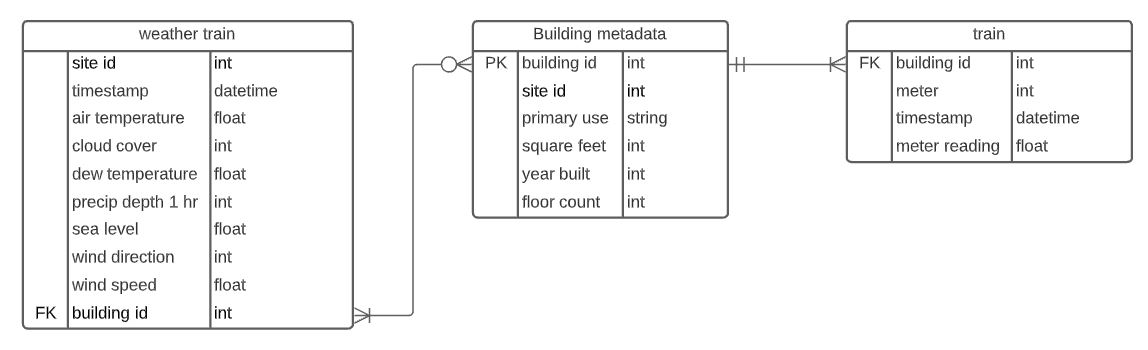

The datasets contain entity relationships as shown above. The train dataset has the same relationship as the test dataset and thus can be illustrated as the train dataset.

The sample submission table contains two columns. The first is a column of indexes for measurement points while the second is a column of estimated/predicted meter readings.

## Proposed Solution

Since we are predicting or estimating a parameter from a set of independent parameters, I would want to use a linear regression model. However, since we also want to improve the accuracy of the model, I want to use the Support Vector Regression (SVR) model for this. A cording to [Wang, 2013](https://ieeexplore.ieee.org/document/6595136), this technique avoids the assumption of linearity in the relationships between features.

The perfromance of this model shall be weighed using the Root Mean Square Logarithmic Error (RMSLE) metric. This is defined in [Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

## Importing Data

1. Libraries and packages

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# importing sklearn packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import lightgbm as lgb
import gc

From Kaggle

In [2]:
!pip install -q kaggle #installing kaggle

In [3]:
from google.colab import files #uploading the json file
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"anthonyigiligi","key":"d99d2a241fd15bdbd5fd1daa7646394f"}'}

In [4]:
! mkdir ~/.kaggle #making a kaggle dir

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/ #adding the json file

In [6]:
! chmod 600 ~/.kaggle/kaggle.json  #file permission

In [7]:
!kaggle competitions download -c ashrae-energy-prediction  #downloading the dataset

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip test.csv.zip
!unzip train.csv.zip
!unzip weather_test.csv.zip
!unzip weather_train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  weather_train.csv.zip
replace weather_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: weather_train.csv       


In [9]:
#train test files
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

#weather files
weather_train_df = pd.read_csv('/content/weather_train.csv')
weather_test_df = pd.read_csv('/content/weather_test.csv')

#building files
building_df = pd.read_csv('/content/building_metadata.csv')

### Data overview and summary statistics


In [10]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [11]:
weather_train_df.tail(1)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139772,15,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [12]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [13]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


There are 139773 entries. They are hourly measurements for each site from 01.01.2016 to 31.12.2016

Let's check the train dataset

In [14]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [15]:
train_df.tail(1)

,building_id,meter,timestamp,meter_reading
20216099,1448,0,2016-12-31 23:00:00,2.85


In [16]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


The training set started and ended on the same date and time as the weather data. The only difference is that the weather data has annual measurements for each site.

Next we create the feather version of the dataset so that the memory usage can reduce drastically.

In [18]:
train_df.to_feather('train_df.feather')
test_df.to_feather('test_df.feather')
building_df.to_feather('building_df.feather')
weather_test_df.to_feather('weather_test_df.feather')
weather_train_df.to_feather('weather_train_df.feather')

In [19]:
train_df = pd.read_feather('train_df.feather')
test_df = pd.read_feather('test_df.feather')
building_df = pd.read_feather('building_df.feather')
weather_test_df = pd.read_feather('weather_test_df.feather')
weather_train_df = pd.read_feather('weather_train_df.feather')

In [20]:
# further reducing the memory to avoid running our of RAM during merging
# this function reduces the memory of individual data types

def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df

In [21]:
train_df = reduce_mem_usage(train_df, 'Trian Dataset')
test_df = reduce_mem_usage(test_df, 'Test Dataset')
building_df = reduce_mem_usage(building_df, 'Building Dataset')
weather_train_df = reduce_mem_usage(weather_train_df, 'Weather train dataset')
weather_test_df = reduce_mem_usage(weather_test_df, 'Weather test dataset')

Memory usage of Trian Dataset is reduced by 71.82 %. Usage dropped from 616.95 MB to 173.84 MB.
Memory usage of Test Dataset is reduced by 71.82 %. Usage dropped from 1272.51 MB to 358.53 MB.
Memory usage of Building Dataset is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather train dataset is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.
Memory usage of Weather test dataset is reduced by 73.04 %. Usage dropped from 19.04 MB to 5.13 MB.


According to the data model above, we have to merge the data such that all the weather and builing tables can be joined to the train dataset.

In [22]:
train_data = train_df.merge(building_df, on='building_id', how='left')
train_data = train_data.merge(weather_train_df, on=['site_id', 'timestamp'],
                              how='left')

In [23]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [24]:
test_data = test_df.merge(building_df, on='building_id', how='left')
test_data = test_data.merge(weather_test_df, on=['site_id','timestamp'],
                            how='left')

Let's seperate the time feature into hours, day, and month for the test_data and train_data respectively. I'll add them as new columns

In [25]:
def breakdown_timestamp(dataframe):

  #convert the date column to datetime format
  dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
  
  #generate the and load the hour, days, months, and years
  dataframe['hour'] = np.int8(dataframe['timestamp'].dt.hour)
  dataframe['day'] = np.int16(dataframe['timestamp'].dt.day)
  dataframe['dayofweek'] = np.int8(dataframe['timestamp'].dt.dayofweek)
  dataframe['dayofyear'] = np.int16(dataframe['timestamp'].dt.dayofyear)
  dataframe['month'] = np.int8(dataframe['timestamp'].dt.month)
  dataframe['year'] = np.int16(dataframe['timestamp'].dt.year)

  return dataframe

In [26]:
# create all the new columns for datetime features
train_data = breakdown_timestamp(train_data)
test_data = breakdown_timestamp(test_data)

In [27]:
print(train_data.shape)
print(test_data.shape)

(20216100, 22)
(41697600, 22)


## Exploratory Data Analysis

Here, we wish to visualize the inherent relatioships that exist withing the dataset and understand the features that have stronger weights that others. Features with strong correlations with the target parameter will be retained for further evaluation.

In [28]:
sns.set_style('darkgrid')

Let's see the distribution of the meter readings

In [29]:
def draw_distribution_graph(dataframe, column_name):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(dataframe[column_name], color='purple', ax = ax).set_title(
        "Distribution Graph for {}".format(column_name), fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


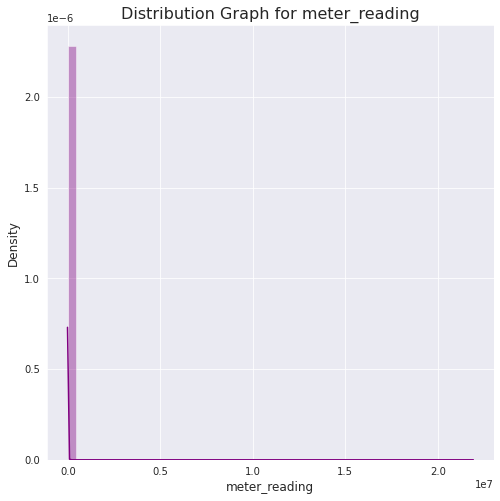

In [30]:
draw_distribution_graph(train_data, 'meter_reading')

This distribution is highy skewed as will be shown bellow using the skew function. Essentially, most of the data points for the meter readings are less the max point.

In [31]:
print('Meter Reading skewness', train_data['meter_reading'].skew())

Meter Reading skewness 104.81131


In other to resolve this, we have to transform the meter reading by log

In [32]:
train_data['meter_reading'] = np.log1p(train_data['meter_reading'])

Let's see it again

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


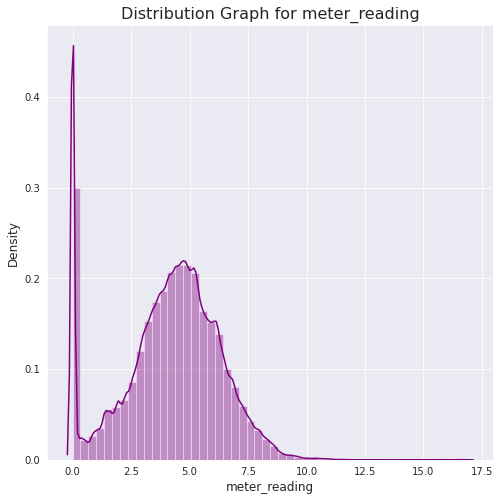

In [33]:
draw_distribution_graph(train_data, 'meter_reading')

In [34]:
print('Meter Reading skewness', train_data['meter_reading'].skew())

Meter Reading skewness -0.27537704


The data is almost normally distributed except for the spike at zero. this will be eliminated during reprocessing

One might want to know how many the total counts of different meter types in the dataset.

Text(0, 0.5, 'Count')

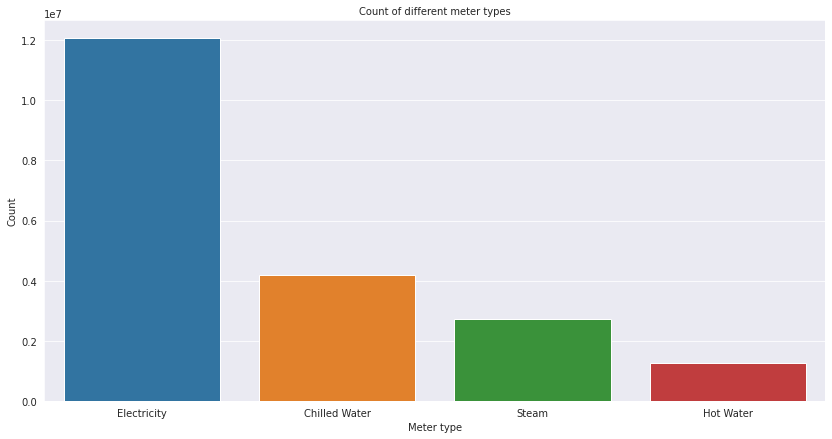

In [36]:
fig, ax = plt.subplots(figsize=(14,7))
meter_types = ['Electricity', 'Chilled Water', 'Steam', 'Hot Water']

sns.countplot(x='meter', data=train_data)
ax.set_xticklabels(meter_types)
ax.set_title('Count of different meter types', fontsize=10)
ax.set_xlabel('Meter type', fontsize=10)
ax.set_ylabel('Count', fontsize=10)

The electricity meter is clearly the most used in the houses, followed by the chilled water meter. The least being the hot water meter

Let's check the meter readings for each meter type

Text(0, 0.5, 'Avg. log readings')

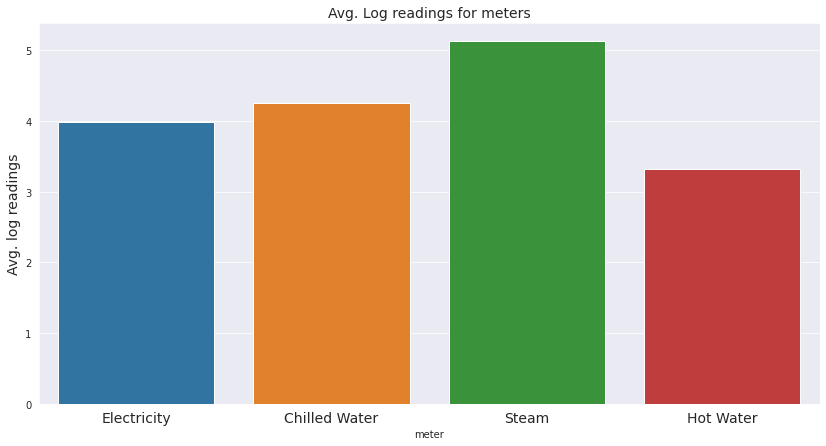

In [37]:
fig, ax = plt.subplots(figsize=(14,7))

meters = train_data.groupby('meter').meter_reading.mean().reset_index()
sns.barplot(x='meter', y='meter_reading', data=meters)
ax.set_title('Avg. Log readings for meters', fontsize=14)
ax.set_xticklabels(meter_types, fontsize=14)
ax.set_ylabel('Avg. log readings', fontsize=14)

The steam data has the higest average log reading compared to the rest of the meters.

The reason for this may lie in the primary use of these buildings. The primary use case with the highest number of buildings might contribute to the variations in the average meter readings.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

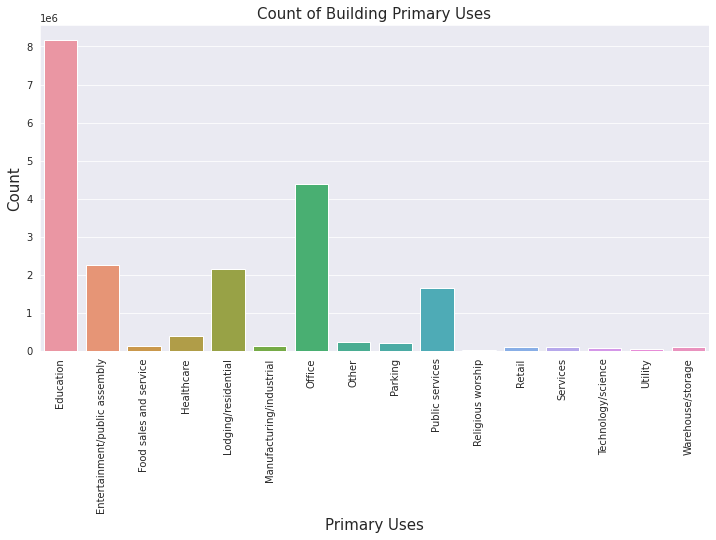

In [42]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot(data=train_data, x='primary_use')
ax.set_title('Count of Building Primary Uses', fontsize=15)
ax.set_xlabel('Primary Uses', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.xticks(rotation=90)

Education buildings have the highest number of buildings in the dataset, followed by offices. One can see the reason why the steam meter has high average values. This is because these cover a large area, therefore requires more heating.

Let's explore the relationship between the average meter readings for a day and a year

Text(0.5, 1.0, 'Monthly averages of meter readings')

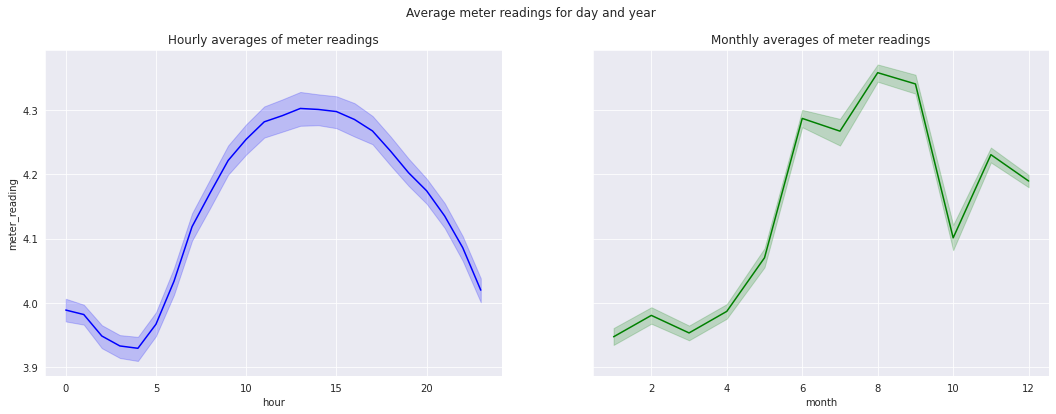

In [48]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(18,6))
fig.suptitle('Average meter readings for day and year')

a_day = train_data.groupby(['timestamp', 'hour']).meter_reading.mean().reset_index()
a_year = train_data.groupby(['timestamp', 'month']).meter_reading.mean().reset_index()

sns.lineplot(x='hour', y='meter_reading', data=a_day, ax=ax[0], color='blue')
ax[0].set_title('Hourly averages of meter readings')
sns.lineplot(x='month', y='meter_reading', data=a_year, ax=ax[1], color='green')
ax[1].set_title('Monthly averages of meter readings')

The daily profile shows that peak energy demand is within working hours (08:00 - 18:00). This is because most of the buildings are primarilly used for education and offices.

The monthly profile shows that peak demand is between May and September. These are summer months where demand for chilled water is higher. 

Next, let us evaluate the missing values from the dataset

In [50]:
null_val = pd.DataFrame(train_data.isnull().sum()*100/len(train_data),
                        columns=['Null Values'])
null_val = null_val[null_val['Null Values'] != 0]
null_val.sort_values(by='Null Values', axis=0,  ascending=False, inplace=True)
null_val

,Null Values
floor_count,82.652772
year_built,59.990033
cloud_coverage,43.655131
precip_depth_1_hr,18.544739
wind_direction,7.167792
sea_level_pressure,6.092515
wind_speed,0.710701
dew_temperature,0.495348
air_temperature,0.478124


Features with more than 10% missing values are not good for modeling. These have to be engineered or eliminated before using them for modeling. The top two features with missing values are the *floor_count* and *year_built*.

#### Cross Correlation

Let's explore the correlation among the features of this dataset.

In [51]:
correlation_matrix = train_data.corr()

Text(0.5, 1.0, 'Correlation Matrix of Features')

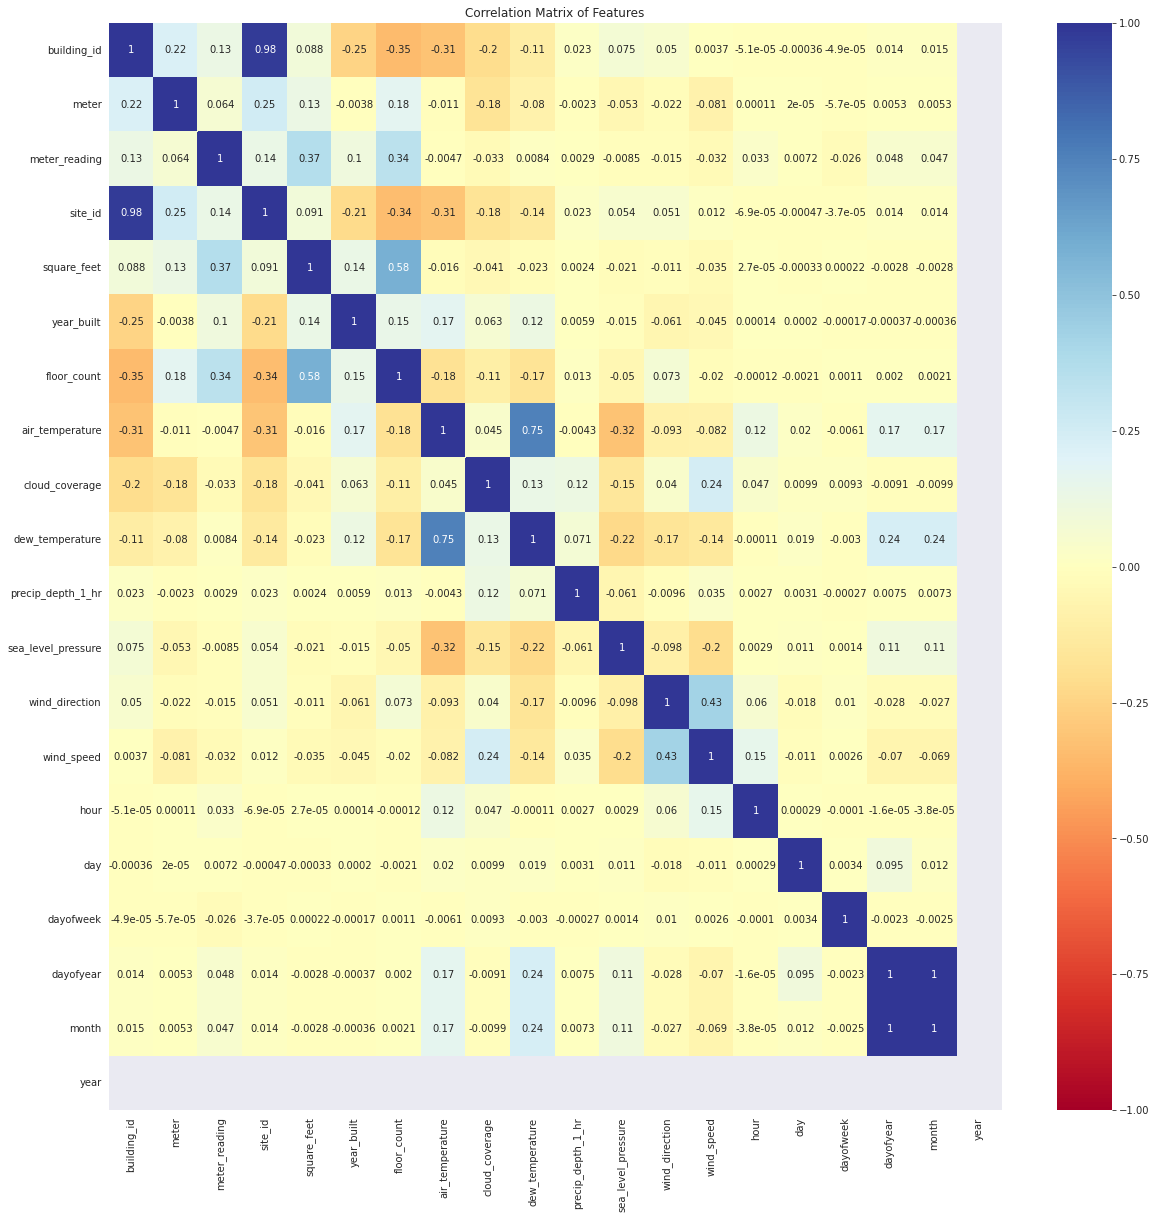

In [54]:
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True,
            vmin=-1, vmax=1,cmap='RdYlBu').set_title(
                'Correlation Matrix of Features'
            )

It can be seen from the heatmap that the building id and its site are perfectly correlated.

Also, the feature with the highest correlation to the meter reading is square_feet. This is because, the larger the square_feet of a house, the higher the energy consumption.

Finally, we can look at the feature distribution for each feature. This will help us select features (if neccessary) for transformation.

Text(0.5, 0.98, 'Histogram of features')

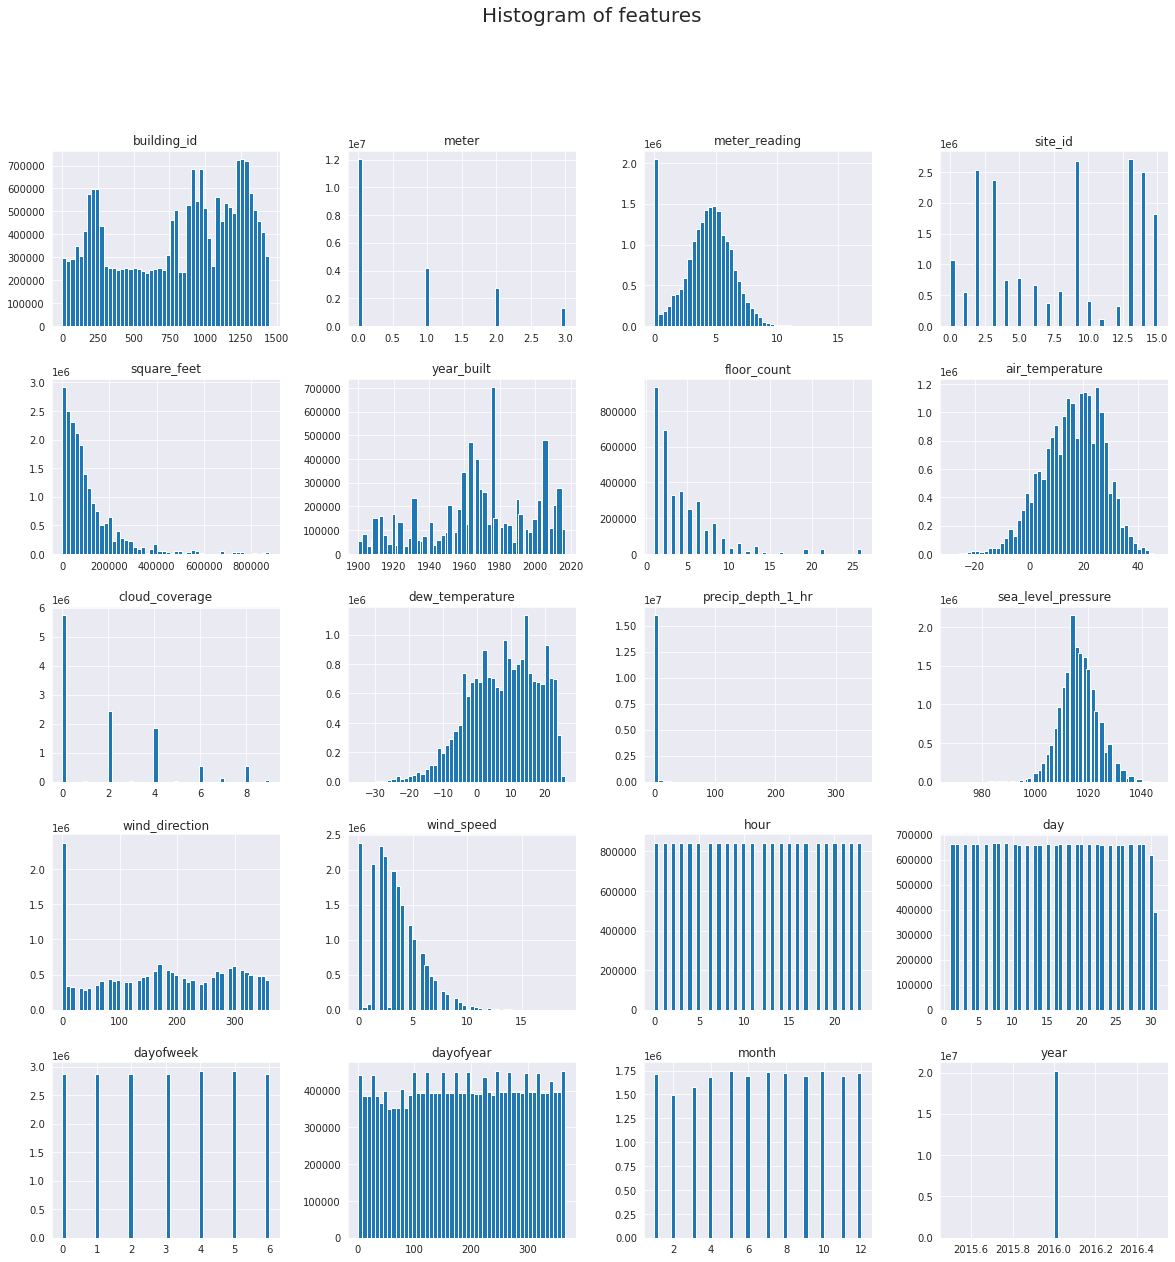

In [56]:
train_data.hist(bins=50, figsize=(20,20))
plt.suptitle('Histogram of features', fontsize=20)

## Feature Engineering

This is the stage where we will prepare each feature according to their distribution and weight. From the previous image, we can see the distribution of each feature and use that as a judgement for selecting which feature needs to be transformed.

The *square_feet* feature is skewed to the left. Thus we have to transform it uing log.

In [58]:
train_data['square_feet'] = np.log1p(train_data['square_feet'])

Further feature preprossessing:
* Eliminating zero-value measurements from the meter readings
* Eliminating columns with more than 50% null values
* Filling in missing values using column median
* Adding new features
* Encoding categorical data

In [59]:
# eliminating zero-value meter readings
null_meter_values = list(train_data[train_data['meter_reading'] == 0].index)
train_data.drop(null_meter_values, axis=0, inplace=True)

In [61]:
# droping columns with more than 50% null values
null_val_drop = len(train_data)*0.5
train_data.dropna(axis=1, thresh=null_val_drop, inplace=True)

In [63]:
# filling in missing values with median of the corresponding column
train_data['cloud_coverage'].fillna(train_data['cloud_coverage'].median(),
                                    inplace=True)
train_data['precip_depth_1_hr'].fillna(train_data['precip_depth_1_hr'].median(),
                                       inplace=True)
train_data['wind_direction'].fillna(train_data['wind_direction'].median(),
                                    inplace=True)
train_data['sea_level_pressure'].fillna(
    train_data['sea_level_pressure'].median(),  inplace=True)
train_data['wind_speed'].fillna(train_data['wind_speed'].median(),
                                inplace=True)
train_data['dew_temperature'].fillna(train_data['dew_temperature'].median(),
                                     inplace=True)
train_data['air_temperature'].fillna(train_data['air_temperature'].median(),
                                     inplace=True)

In [65]:
train_data.isnull().sum() / len(train_data)

building_id           0.0
meter                 0.0
timestamp             0.0
meter_reading         0.0
site_id               0.0
primary_use           0.0
square_feet           0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
hour                  0.0
day                   0.0
dayofweek             0.0
dayofyear             0.0
month                 0.0
year                  0.0
dtype: float64

Let's add additional datetime feature. This time, the new features will represent the *seasons* and *day/night*

In [66]:
train_data['season'] = \
train_data['timestamp'].apply(lambda x:
                              'Spring' if x.month==3 or
                              x.month==4 or x.month==5 else
                              'Summer' if x.month==6 or
                              x.month==7 or x.month==8 else
                              'Automn' if x.month==9 or x.month==10 or
                              x.month==11 else 'Winter')
train_data['isdaytime'] = \
train_data['timestamp'].apply(lambda x: 1 if x.hour>=6 and x.hour<=18 else 0)

In [69]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isdaytime
45,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,0,1,4,1,1,2016,Winter,0
72,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,0,1,4,1,1,2016,Winter,0
91,93,0,2016-01-01,3.978196,0,Office,10.415443,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000,0,1,4,1,1,2016,Winter,0
103,105,0,2016-01-01,3.190624,1,Education,10.832181,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1,2016,Winter,0
104,106,0,2016-01-01,0.318163,1,Education,8.589514,3.800781,0.0,2.400391,0.0,1021.0,240.0,3.099609,0,1,4,1,1,2016,Winter,0


Encoding categorical features

